In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()


In [2]:
def plot_rollout(sim):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
  ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  plt.show()

In [28]:
import numpy as np
import numpy as np
import scipy.linalg as la
import math

class PendoLQR():
  """
  Pendolino LQR controller
  """
  def __init__(self,):
    self.p = 0.3
    self.i = 0.05
    self.d = -0.1
    self.error_integral = 0
    self.prev_error = 0

  def solve_DARE(self,A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    X = Q
    Xn = Q
    max_iter = 150
    eps = 0.01

    for i in range(max_iter):
        Xn = A.T @ X @ A - A.T @ X @ B @ \
            la.inv(R + B.T @ X @ B) @ B.T @ X @ A + Q
        if (abs(Xn - X)).max() < eps:
            break
        X = Xn

    return Xn


  def dlqr(self, A, B, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = self.solve_DARE(A, B, Q, R)

    # compute the LQR gain
    K = la.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

    eigVals, eigVecs = la.eig(A - B @ K)

    return K, X, eigVals

  def update(self, target_lataccel, current_lataccel, state, future_plan):  
    # implement LQR controller for a desired lateral acceleration
    # state is the current state of the vehicle
    # future_plan is the future plan of the vehicle
    # target_lataccel is the desired lateral acceleration
    # current_lataccel is the current lateral acceleration
    # return the desired lateral acceleration

    v = 3.8
    L = 2.5
    dt = 0.1

    # LQR parameter
    Q = np.eye(4)
    R = np.eye(1)
    
    A = np.zeros((4, 4))
    A[0, 0] = 1.0
    A[0, 1] = dt
    A[1, 2] = v
    A[2, 2] = 1.0
    A[2, 3] = dt
    # print(A)

    B = np.zeros((4, 1))
    B[3, 0] = v / L

    K, _, _ = self.dlqr(A, B, Q, R)

    x = np.zeros((4, 1))

    error = target_lataccel - current_lataccel

    x[0, 0] = error
    x[1, 0] = 0
    x[2, 0] = 0
    x[3, 0] = 0

    
    return (K @ x)[0,0]

In [29]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller = PendoLQR()

In [30]:
sim = TinyPhysicsSimulator(model, "./data/00000.csv", controller=controller, debug=False)
sim.rollout()

{'lataccel_cost': 12.72758267318915,
 'jerk_cost': 43.94524656014634,
 'total_cost': 680.3243802196039}

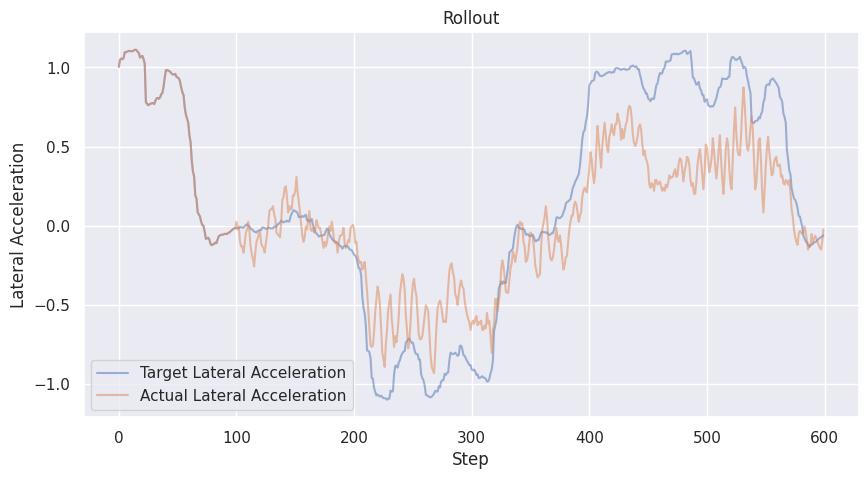

In [31]:
plot_rollout(sim)